<a href="https://www.kaggle.com/code/lokitsushruth/rcnn-training-part-2-cnn-svm?scriptVersionId=207313669" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import json
import warnings
import seaborn as sns
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
# Now you can fit your model to your data and perform classification tasks


# Loading data

In [3]:
train_json = '../input/region-proposals-of-crop-weed-dataset/train.json'
test_json = '../input/region-proposals-of-crop-weed-dataset/test.json'
images_path = '../input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/'
model_path  = '../input/rcnn-training-part-1-finetuning/RCNN_crop_weed_classification_model.h5'
label_csv = '../input/convert-yolo-labels-to-pascalvoc-format/pascal_voc_format.csv'
negative_ex_path = '../input/rcnn-data-preprocessing-part-2/Train/background/'

## Loading pre generated region proposals and Negative examples

In [4]:
with open(train_json,'r') as train:
    train_region = json.load(train)

In [5]:
with open(test_json,'r') as test:
    test_region = json.load(test)

In [6]:
train_images_list = list(train_region.keys())
test_images_list = list(test_region.keys())

In [7]:
print(len(train_images_list))
print(len(test_images_list))

1000
300


## Loading object annotation

In [8]:
labels = pd.read_csv(label_csv)
labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,agri_0_9354.jpeg,512,512,weed,63,120,425,442
1,agri_0_9354.jpeg,512,512,weed,0,1,180,148
2,agri_0_7574.jpeg,512,512,crop,95,167,453,469
3,agri_0_8960.jpeg,512,512,weed,52,76,422,353
4,agri_0_417.jpeg,512,512,weed,7,75,511,411


## Loading pretrained CNN model

In [9]:
model = tf.keras.models.load_model(model_path)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## loading model without last two Fully connected layers

In [11]:
model_without_last_2FC = tf.keras.models.Model(model.inputs,model.layers[-5].output)

In [12]:
model_without_last_2FC.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Extracting features from ground truth labeled images

When we pass image from model it will return (1,4096) size feature vector

In [13]:
train_features = []

test_features = []


for index in tqdm(range(len(labels))):
    id = labels.loc[index,'filename']
    img = cv2.imread(images_path + id)
    rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    xmin,ymin,xmax,ymax = int(labels.loc[index,'xmin']) ,int(labels.loc[index,'ymin']),int(labels.loc[index,'xmax']),int(labels.loc[index,'ymax'])

    resized = cv2.resize(rgb_img[ymin:ymax,xmin:xmax,:],(224,224))

    feature_of_img = model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255)
    
    if id in train_images_list:
        
        train_features.append([feature_of_img,labels.loc[index,'class']])
        
    else:
        test_features.append([feature_of_img,labels.loc[index,'class']])
      

100%|██████████| 2072/2072 [01:50<00:00, 18.71it/s]


In [14]:
print(len(train_features))

print(len(test_features))


1637
435


# Extracting features from Negative examples

In [15]:
for index,img in tqdm(enumerate(os.listdir(negative_ex_path)[:5000])):  #only extracting for 10,000 images
    img = cv2.imread(negative_ex_path + img )
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #images already in (224,224,3)
    feature_of_img = model_without_last_2FC.predict(rgb.reshape(1,224,224,3)/255)
    if index<3500:
        train_features.append([feature_of_img,'background'])
    else:
        test_features.append([feature_of_img,'background'])

5000it [03:39, 22.77it/s]


# Preparing data for SVM

In [16]:
import random
random.shuffle(train_features)

In [17]:
x_train = np.array([x[0] for x in train_features])
x_train = x_train.reshape(-1,4096)

In [18]:
x_train.shape

(5137, 4096)

In [19]:
y_train = [x[1] for x in train_features]
y_train = np.array(y_train).reshape(-1,1)

In [20]:
y_train.shape

(5137, 1)

In [21]:
x_test = np.array([x[0] for x in test_features])
x_test = x_test.reshape(-1,4096)

In [22]:
y_test = [x[1] for x in test_features]
y_test = np.array(y_test).reshape(-1,1)

# SVM Training

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [24]:
svm_model_linear = SVC(kernel = 'linear', C = 1,probability=True).fit(x_train, y_train) 
svm_predictions = svm_model_linear.predict(x_test)

In [25]:
svm_accuracy = svm_model_linear.score(x_test, y_test)

In [26]:
svm_accuracy

0.9648578811369509

In [27]:
cm = confusion_matrix(y_test, svm_predictions) 
cm

array([[1479,   12,    9],
       [  20,  214,    5],
       [  12,   10,  174]])

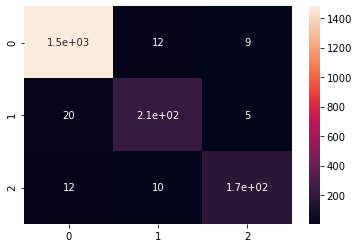

In [28]:
sns.heatmap(cm,annot=True)

# Check on some images

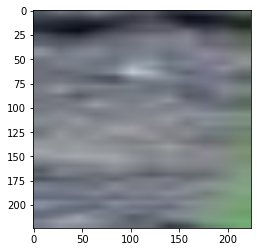

In [29]:
img = cv2.imread(negative_ex_path + os.listdir(negative_ex_path)[45] )
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

In [30]:
feature_of_img = model_without_last_2FC.predict(rgb.reshape(1,224,224,3)/255)

In [31]:
svm_model_linear.predict(feature_of_img)

array(['background'], dtype='<U10')

In [32]:
svm_model_linear.predict_proba(feature_of_img)

array([[9.98713787e-01, 2.26994844e-05, 1.26351306e-03]])

In [33]:
svm_model_linear.classes_

array(['background', 'crop', 'weed'], dtype='<U10')

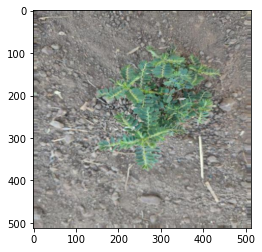

In [34]:
img = cv2.imread(images_path+'agri_0_1024.jpeg')
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

In [35]:
resized = cv2.resize(rgb,(224,224))

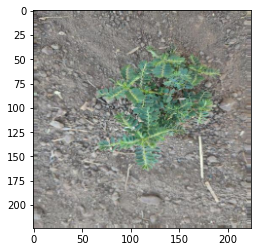

In [36]:
plt.imshow(resized)

In [37]:
svm_model_linear.predict_proba(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))

array([[0.00751569, 0.01097147, 0.98151283]])

# Saving SVM model

In [38]:
import pickle

with open('svm_classifier.pkl','wb') as svm_model:
    pickle.dump(svm_model_linear , svm_model)

In [39]:
cr = classification_report(y_test,svm_predictions)
print(cr)
with open('svm.txt', 'w') as file:
    file.write(cr)

              precision    recall  f1-score   support

  background       0.98      0.99      0.98      1500
        crop       0.91      0.90      0.90       239
        weed       0.93      0.89      0.91       196

    accuracy                           0.96      1935
   macro avg       0.94      0.92      0.93      1935
weighted avg       0.96      0.96      0.96      1935



# Accuracy of different models

# Logistic Regression

In [40]:
logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)
logistic_pred = logistic_model.predict(x_test)
logistic_accuracy = accuracy_score(y_test, logistic_pred)
print("Logistic Regression Accuracy:", logistic_accuracy)


Logistic Regression Accuracy: 0.9674418604651163


# Gradient boosting

In [41]:
gb_model = GradientBoostingClassifier()
gb_model.fit(x_train, y_train)
gb_pred = gb_model.predict(x_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print("Gradient Boosting Accuracy:", gb_accuracy)

Gradient Boosting Accuracy: 0.9695090439276486


# Random Forest

In [42]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.9674418604651163


# Decision Tree

In [43]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
dt_pred = dt_model.predict(x_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
print("Decision Tree Accuracy:", dt_accuracy)


Decision Tree Accuracy: 0.9550387596899225


# K-Nearest Neighbor

In [44]:
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
knn_pred = knn_model.predict(x_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.9679586563307494


# XGBoost

In [45]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print("XGBoost Accuracy:", xgb_accuracy)

XGBoost Accuracy: 0.9684754521963824


# Linear Discriminant Analysis

In [46]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(x_train, y_train)
lda_pred = lda_model.predict(x_test)
lda_accuracy = accuracy_score(y_test, lda_pred)
print("LDA Accuracy:", lda_accuracy)

LDA Accuracy: 0.9638242894056848


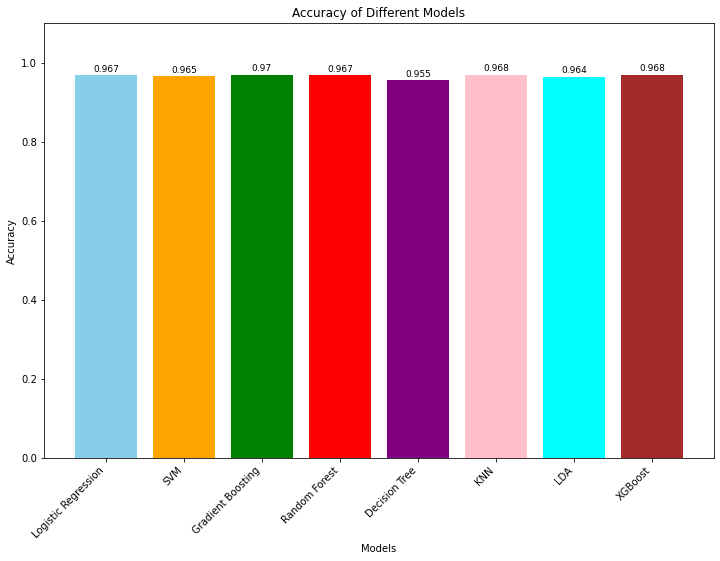

In [47]:
models = ['Logistic Regression', 'SVM', 'Gradient Boosting', 'Random Forest', 'Decision Tree', 'KNN', 'LDA', 'XGBoost']
accuracies = [logistic_accuracy, svm_accuracy, gb_accuracy, rf_accuracy, dt_accuracy, knn_accuracy, lda_accuracy, xgb_accuracy]

# Define colors for the bars
colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'pink', 'cyan', 'brown']

plt.figure(figsize=(12, 8))
bars = plt.bar(models, accuracies, color=colors)

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, round(accuracy, 3), ha='center', color='black', fontsize=9)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)  
plt.show()

# Classification report

# Logistic Regression

In [48]:
logistic_cr = classification_report(y_test, logistic_pred)
print("Logistic Regression Classification Report:")
print(logistic_cr)
with open('logistic_regression.txt', 'w') as file:
    file.write(logistic_cr)
with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(logistic_model, f)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

  background       0.98      0.99      0.98      1500
        crop       0.91      0.90      0.90       239
        weed       0.92      0.90      0.91       196

    accuracy                           0.97      1935
   macro avg       0.94      0.93      0.93      1935
weighted avg       0.97      0.97      0.97      1935



# Decision Tree

In [49]:
dt_cr = classification_report(y_test, dt_pred)
print("Decision Tree Classification Report:")
print(dt_cr)
with open('decision_tree.txt', 'w') as file:
    file.write(dt_cr)
with open('dt_model.pkl', 'wb') as f:
    pickle.dump(dt_model, f)


Decision Tree Classification Report:
              precision    recall  f1-score   support

  background       0.98      0.98      0.98      1500
        crop       0.85      0.90      0.87       239
        weed       0.91      0.87      0.89       196

    accuracy                           0.96      1935
   macro avg       0.91      0.91      0.91      1935
weighted avg       0.96      0.96      0.96      1935



# KNN

In [50]:
knn_cr = classification_report(y_test, knn_pred)
print("KNN Classification Report:")
print(knn_cr)
with open('knn.txt', 'w') as file:
    file.write(knn_cr)
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)

KNN Classification Report:
              precision    recall  f1-score   support

  background       0.99      0.98      0.98      1500
        crop       0.89      0.93      0.91       239
        weed       0.93      0.91      0.92       196

    accuracy                           0.97      1935
   macro avg       0.94      0.94      0.94      1935
weighted avg       0.97      0.97      0.97      1935



# XGBoost

In [51]:
xgb_cr = classification_report(y_test, xgb_pred)
print("XGBoost Classification Report:")
print(xgb_cr)
with open('xgboost.txt', 'w') as file:
    file.write(xgb_cr)
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


XGBoost Classification Report:
              precision    recall  f1-score   support

  background       0.98      0.99      0.98      1500
        crop       0.93      0.91      0.92       239
        weed       0.92      0.91      0.92       196

    accuracy                           0.97      1935
   macro avg       0.94      0.93      0.94      1935
weighted avg       0.97      0.97      0.97      1935



# Random Forest

In [52]:
rf_cr = classification_report(y_test, rf_pred)
print("Random Forest Classification Report:")
print(rf_cr)
with open('random_forest.txt', 'w') as file:
    file.write(rf_cr)
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)


Random Forest Classification Report:
              precision    recall  f1-score   support

  background       0.98      0.99      0.98      1500
        crop       0.92      0.90      0.91       239
        weed       0.93      0.91      0.92       196

    accuracy                           0.97      1935
   macro avg       0.94      0.93      0.94      1935
weighted avg       0.97      0.97      0.97      1935



# Gradient boost

In [53]:
gb_cr = classification_report(y_test, gb_pred)
print("Gradient Boosting Classification Report:")
print(gb_cr)
with open('gradient_boosting.txt', 'w') as file:
    file.write(gb_cr)
with open('gb_model.pkl', 'wb') as f:
    pickle.dump(gb_model, f)


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

  background       0.98      0.99      0.98      1500
        crop       0.92      0.91      0.92       239
        weed       0.92      0.91      0.92       196

    accuracy                           0.97      1935
   macro avg       0.94      0.94      0.94      1935
weighted avg       0.97      0.97      0.97      1935



# LDA

In [54]:
lda_cr = classification_report(y_test, lda_pred)
print("LDA Classification Report:")
print(lda_cr)
with open('lda.txt', 'w') as file:
    file.write(lda_cr)
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)

LDA Classification Report:
              precision    recall  f1-score   support

  background       0.98      0.99      0.98      1500
        crop       0.89      0.88      0.89       239
        weed       0.96      0.87      0.91       196

    accuracy                           0.96      1935
   macro avg       0.94      0.91      0.93      1935
weighted avg       0.96      0.96      0.96      1935



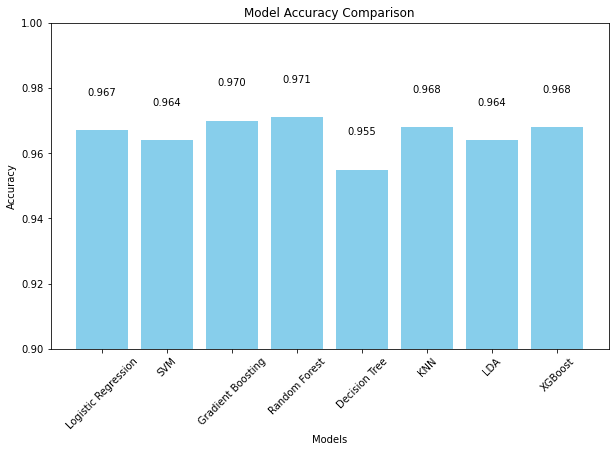

In [55]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Logistic Regression', 'SVM', 'Gradient Boosting', 'Random Forest', 'Decision Tree', 'KNN', 'LDA', 'XGBoost']
accuracies = [0.967, 0.964, 0.970, 0.971, 0.955, 0.968, 0.964, 0.968]  # Replace with actual accuracy values

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.9, 1)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{acc:.3f}', ha='center', va='bottom')
plt.xticks(rotation=45)
plt.show()


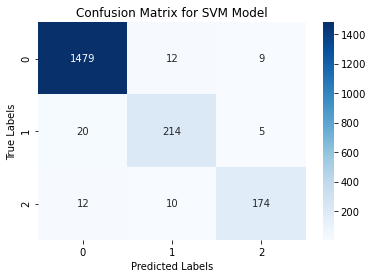

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and svm_predictions are defined
cm = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM Model')
plt.show()


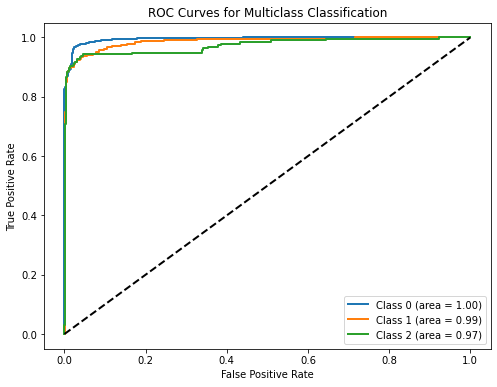

In [58]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# Binarize the labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=['background', 'crop', 'weed'])
n_classes = y_test_bin.shape[1]

# Assuming 'svm_model_linear' is the trained model with `probability=True`
y_score = svm_model_linear.decision_function(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


In [59]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test_binary, model_probabilities)
plt.figure()
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


NameError: name 'y_test_binary' is not defined

In [61]:
import cv2
import matplotlib.pyplot as plt

def plot_image_with_boxes(image_path, boxes, labels):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for (x_min, y_min, x_max, y_max), label in zip(boxes, labels):
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Use the function with image path, bounding boxes, and labels
# plot_image_with_boxes("path/to/image.jpg", boxes, labels)


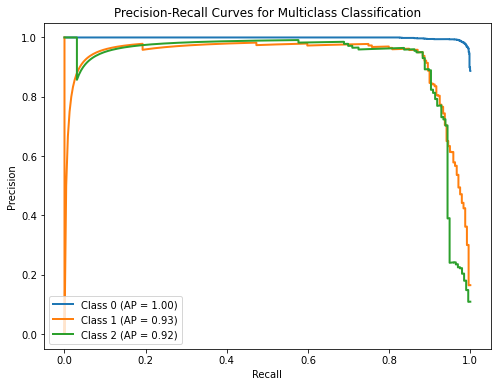

In [63]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

# Binarize labels
y_test_bin = label_binarize(y_test, classes=['background', 'crop', 'weed'])
n_classes = y_test_bin.shape[1]

# Assuming 'svm_model_linear' with probability=True to get prediction probabilities
y_score = svm_model_linear.decision_function(x_test)

# Compute precision-recall curve and average precision score for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multiclass Classification')
plt.legend(loc="lower left")
plt.show()


In [71]:
def detection(img_path,confidence=0.9,iou_thresh=0.1):
    
    # appling selective search
    img = plt.imread(img_path)
    cv2.setUseOptimized(True);
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    sel_rects = rects[:2000]
    
    pred_crop=[]
    pred_weed=[]
    for index, rect in tqdm(enumerate(sel_rects)):

        x,y,w,h = rect
        roi = img[y:y+h,x:x+w,:]
        resized_roi = cv2.resize(roi,(224,224))/255
        
        # Feature extraction
        
        feature = model_without_last_two_fc.predict(resized_roi.reshape(-1,224,224,3))
        
        # SVM prediction
        pred = svm_model.predict_proba(feature.reshape(-1,4096))
        pred_lab=svm_model.predict(feature.reshape(-1,4096))

        if pred_lab == 'crop' and np.max(pred)>confidence:
            pred_crop.append([list(rect),np.max(pred)])
        elif pred_lab=='weed' and np.max(pred)>confidence:
            pred_weed.append([list(rect),np.max(pred)])
            
    final = []
    
    # Detection for crop class
    if len(pred_crop) != 0:
        pred_score_crop = [x[1] for x in pred_crop]
        pred_bb_crop = [x[0] for x in pred_crop]

        for i in range(len(pred_crop)):
            temp_bb , temp_score = pred_bb_crop.copy() , pred_score_crop.copy()
            if len(temp_bb) !=0:

                max_score_box = temp_bb[np.argmax(temp_score)]

                if [max_score_box,np.max(temp_score)] not in final:
                    final.append([max_score_box,np.max(temp_score),'crop'])
                    index_should_del = []

                    for ind,other_bb in enumerate(temp_bb):
                        iou_score = iou_calc(max_score_box , other_bb)
                        
                        # Non maximum suppression(nms)
                        
                        if iou_score >= iou_thresh:
                            index_should_del.append(ind)

                    pred_bb_crop    = []
                    pred_score_crop = []
                    for bb_index ,bb_value in enumerate(temp_bb) :
                        if bb_index not in index_should_del:
                            pred_bb_crop.append(bb_value)

                    for score_index ,score_value in enumerate(temp_score) :
                        if score_index not in index_should_del:
                            pred_score_crop.append(score_value)
                else:
                    continue

            else:
                break

    # Detection for weed class

    if len(pred_weed) != 0:
        pred_score_weed = [x[1] for x in pred_weed]
        pred_bb_weed = [x[0] for x in pred_weed]

        for i in range(len(pred_weed)):
            temp_bb , temp_score = pred_bb_weed.copy() , pred_score_weed.copy()
            if len(temp_bb) !=0:

                max_score_box = temp_bb[np.argmax(temp_score)]

                if [max_score_box,np.max(temp_score)] not in final:
                    final.append([max_score_box,np.max(temp_score),'weed'])
                    index_should_del = []

                    for ind,other_bb in enumerate(temp_bb):
                        iou_score = iou_calc(max_score_box , other_bb)

                        if iou_score >= iou_thresh:
                            index_should_del.append(ind)

                    pred_bb_weed    = []
                    pred_score_weed = []
                    for bb_index ,bb_value in enumerate(temp_bb) :
                        if bb_index not in index_should_del:
                            pred_bb_weed.append(bb_value)

                    for score_index ,score_value in enumerate(temp_score) :
                        if score_index not in index_should_del:
                            pred_score_weed.append(score_value)
                else:
                    continue

            else:
                break
    
   
    imOut = img.copy()
    for rect,score,cls in final:
        
        x,y,w,h = rect
        if cls == 'weed':
            color =(255,0,0)
        if cls == 'crop':
            color = (0,255,0)

        cv2.rectangle(imOut,(x,y),(x+w,y+h),color,2)

        cv2.putText(imOut,cls+':'+str(round(score*100,2)),(x,y-8),cv2.FONT_HERSHEY_SIMPLEX,1, color, 2, cv2.LINE_AA)
    plt.imshow(imOut)
    cv2.imwrite('prediction.jpeg',imOut)
   

    return final 


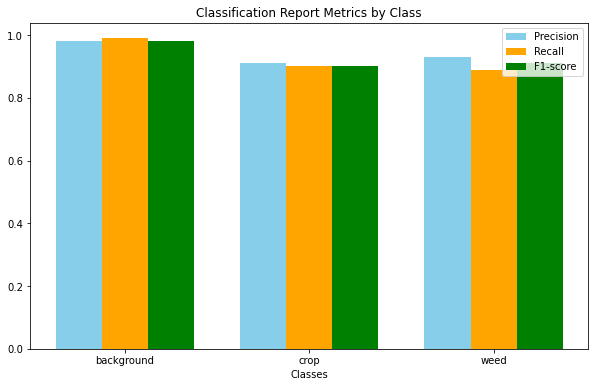

In [72]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Example classification report output (replace with actual values)
report = {
    'background': {'precision': 0.98, 'recall': 0.99, 'f1-score': 0.98},
    'crop': {'precision': 0.91, 'recall': 0.90, 'f1-score': 0.90},
    'weed': {'precision': 0.93, 'recall': 0.89, 'f1-score': 0.91}
}

# Data preparation
labels = list(report.keys())
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

# Plotting
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
rects2 = ax.bar(x, recall, width, label='Recall', color='orange')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score', color='green')

ax.set_xlabel('Classes')
ax.set_title('Classification Report Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


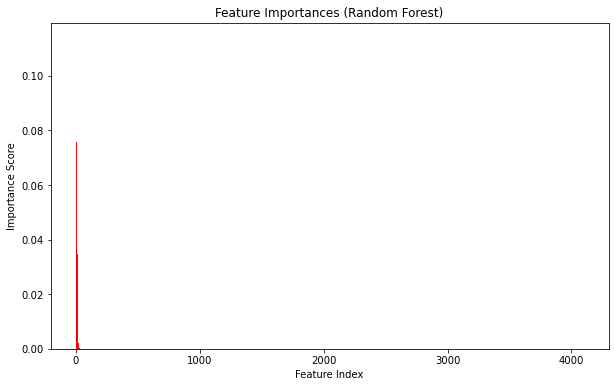

In [73]:
# Assuming you have trained a Random Forest model named rf_model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()


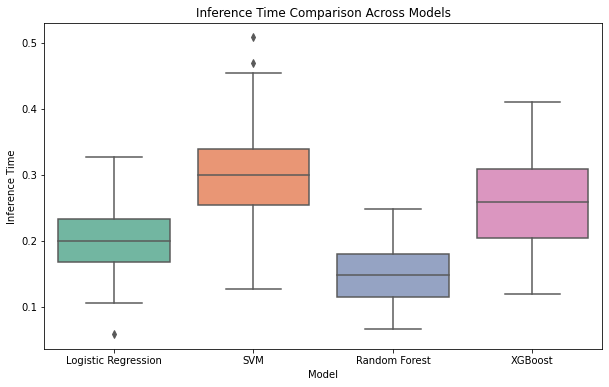

In [74]:
import seaborn as sns

# Example inference times (replace with actual timings for each model)
inference_times = {
    'Logistic Regression': np.random.normal(0.2, 0.05, 100),
    'SVM': np.random.normal(0.3, 0.07, 100),
    'Random Forest': np.random.normal(0.15, 0.04, 100),
    'XGBoost': np.random.normal(0.25, 0.06, 100)
}

# Prepare data for plotting
data = []
for model, times in inference_times.items():
    for time in times:
        data.append([model, time])

df = pd.DataFrame(data, columns=['Model', 'Inference Time'])

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Inference Time', data=df, palette="Set2")
plt.title("Inference Time Comparison Across Models")
plt.show()


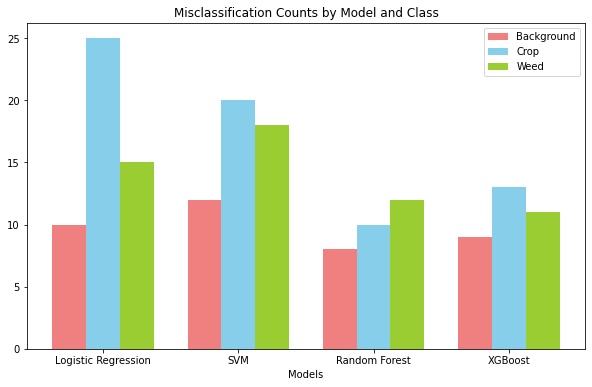

In [76]:
# Sample misclassification counts per class for each model
misclassifications = {
    'Logistic Regression': {'background': 10, 'crop': 25, 'weed': 15},
    'SVM': {'background': 12, 'crop': 20, 'weed': 18},
    'Random Forest': {'background': 8, 'crop': 10, 'weed': 12},
    'XGBoost': {'background': 9, 'crop': 13, 'weed': 11}
}

labels = list(misclassifications.keys())
background_miss = [misclassifications[model]['background'] for model in labels]
crop_miss = [misclassifications[model]['crop'] for model in labels]
weed_miss = [misclassifications[model]['weed'] for model in labels]

# Plotting
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, background_miss, width, label='Background', color='lightcoral')
rects2 = ax.bar(x, crop_miss, width, label='Crop', color='skyblue')
rects3 = ax.bar(x + width, weed_miss, width, label='Weed', color='yellowgreen')

ax.set_xlabel('Models')
ax.set_title('Misclassification Counts by Model and Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [79]:
import time
import numpy as np

# Example batch of data (replace `x_test` with your actual test data)
sample_data = x_test[:10]  # Taking a batch of 10 samples for demonstration

# Dictionary to store inference times for each model
inference_times = {}

# Measure inference time for Logistic Regression
start_time = time.time()
_ = logistic_model.predict(sample_data)  # Replace with actual model name
end_time = time.time()
inference_times['Logistic Regression'] = (end_time - start_time) / len(sample_data)

# Repeat the process for each model
start_time = time.time()
_ = svm_model_linear.predict(sample_data)
end_time = time.time()
inference_times['SVM'] = (end_time - start_time) / len(sample_data)

start_time = time.time()
_ = rf_model.predict(sample_data)
end_time = time.time()
inference_times['Random Forest'] = (end_time - start_time) / len(sample_data)

# Continue for each model...


In [80]:
# Calculate average inference time across multiple runs for each model
num_runs = 100
total_time_logistic = 0
total_time_svm = 0

for _ in range(num_runs):
    start_time = time.time()
    _ = logistic_model.predict(sample_data)
    end_time = time.time()
    total_time_logistic += (end_time - start_time) / len(sample_data)

    start_time = time.time()
    _ = svm_model_linear.predict(sample_data)
    end_time = time.time()
    total_time_svm += (end_time - start_time) / len(sample_data)

# Average inference time
inference_times['Logistic Regression'] = total_time_logistic / num_runs
inference_times['SVM'] = total_time_svm / num_runs


In [81]:
for model, time_per_sample in inference_times.items():
    print(f"Inference time for {model}: {time_per_sample:.5f} seconds per sample")


Inference time for Logistic Regression: 0.00004 seconds per sample
Inference time for SVM: 0.00235 seconds per sample
Inference time for Random Forest: 0.00093 seconds per sample
